This notebook is written  by Salomo Lassfolk for CS-E5770 - Special Course in Complex Systems D: Applied Data Science for Policy Research course project group 6.

You need data from course data folder and Twitter API access to run every function in this notebook.
Have the data folder in the same folder as this notebook and also creating a obj named folder if you wish to pickle some of the results.

In [ ]:
import tweepy

In [2]:
#replace with your own twitter consumer keys and acess tokens.
consumer_key = 'XXX'
consumer_secret = 'XXX'
access_token = 'XXX-XXX'
access_token_secret = 'XXX'

In [3]:
#TwitterAPI access
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)

In [4]:
#Change to True if you wish to use functions that use Twitter API to download information
load_data = False

In [5]:
#Data filenames to a list
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir("data") if isfile(join("data", f))]

In [6]:
onlyfiles

['jäämerenrata_users_1037288666476027904.json',
 'jäämerenrata_users_1187382867694964737.json',
 'jäämerenrata_users_1272440643944669184.json',
 'jäämerenrata_users_1050317943056322563.json',
 'jäämerenrata_data_972487749419896833.json',
 'jäämerenrata_users_1127335755712483328.json',
 'arcticrailway_data_1096277959604879360.json',
 'jäämerenrata_data_974746995519840257.json',
 'jäämerenrata_users_974746995519840257.json',
 'jäämerenrata_users_972487749419896833.json',
 'arcticrail_users_950942433067515904.json',
 'jäämerenrata_data_1126555998695698434.json',
 '.DS_Store',
 'jäämerenrata_data_1106158928533090304.json',
 'jäämerenrata_users_1082935260407508992.json',
 'jäämerenrata_users_1132349770599677952.json',
 'jäämerenrata_data_980791182119919617.json',
 'jäämerenrata_users_1094894909369344005.json',
 'jäämerenrata_users_980791182119919617.json',
 'arcticrailway_data_1131483751240937472.json',
 'arcticrailway_users_982257184640712705.json',
 'noarct

In [7]:

import pickle
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [8]:
#divide the files by their content
users_files = []
data_files = []
for i in onlyfiles:
    split = i.split('_')
    if split[1] == 'users':
        users_files.append(i)
    elif split[1] == 'data':
        data_files.append(i)

In [9]:
#test cell
import json
  
f = open('data/'+data_files[1],)
data = json.load(f)
data[0]

{'entities': {'hashtags': [{'start': 87, 'end': 95, 'tag': 'Finland'},
   {'start': 96, 'end': 105, 'tag': 'Helsinki'},
   {'start': 106, 'end': 111, 'tag': 'Sámi'},
   {'start': 112, 'end': 118, 'tag': 'youth'},
   {'start': 119, 'end': 133, 'tag': 'demonstration'}],
  'mentions': [{'start': 3, 'end': 11, 'username': 'ylenews'}],
  'urls': [{'start': 63,
    'end': 86,
    'url': 'https://t.co/PU1wgTjylv',
    'expanded_url': 'https://yle.fi/uutiset/10796067',
    'display_url': 'yle.fi/uutiset/107960…'}],
  'annotations': {}},
 'id': '1131482581604732928',
 'conversation_id': '1131482581604732928',
 'possibly_sensitive': False,
 'source': 'Twitter Web Client',
 'created_at': '2019-05-23T08:50:44.000Z',
 'text': 'RT @ylenews: Sámi youth group protests proposed Arctic Railway https://t.co/PU1wgTjylv\n#Finland #Helsinki #Sámi #youth #demonstration #arct…',
 'public_metrics': {'retweet_count': 39,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0},
 'author_id': '8863959927734476

In [10]:
import numpy as np
import pandas as pd
def read_data_files(data_files):
    '''
    Takes in data_files as list of file names in data folder.
    Returns a pandas dataframe with 'search_word','tweet_id','author_id','hashtags','mentions','retweet','created_at'
    as columns
    '''
    search_word = []
    tweet_id = []
    author_id = []
    hashtags = []
    retweet = []
    mentions = []
    created_at = []
    for file in data_files:
        f = open('data/'+file,)
        data = json.load(f)
        for tweet in data:
            search_word.append(file.split('_')[0])
            author_id.append(tweet['author_id'])
            tweet_id.append(tweet['id'])
            tags_used = []
            for tags in tweet['entities']['hashtags']:
                tags_used.append(tags['tag'])
            mentions_used = []
            for mention in tweet['entities']['mentions']:
                mentions_used.append(mention['username'])
            mentions.append(mentions_used)
            hashtags.append(tags_used)
            retweet_from = None
            for ref in tweet['referenced_tweets']:
                if ref['type'] == 'retweeted':
                    retweet_from = ref['id']
            retweet.append(retweet_from)
            created_at.append(tweet['created_at'])
    ret = pd.DataFrame(list(zip(search_word,tweet_id,author_id,hashtags,mentions,retweet,created_at)),
               columns =['search_word','tweet_id','author_id','hashtags','mentions','retweet','created_at'])
    return ret

In [11]:
import math
import numpy as np

def get_full_text(tweet_ids):
    '''
    Takes in tweet_ids as list to download from twitter API using extended mode.
    Returns a pandas data frame with 'tweet_id','author','text','hashtags','mentions','created_at'
    as columns
    '''
    tweet_id = []
    author = []
    hashtags = []
    mentions = []
    created_at = []
    text = []
    #separate the list into chunks of 100 ids
    id_lists = np.array_split(tweet_ids, math.ceil((len(tweet_ids))/100))
    for id_list in id_lists:
        #ask api for the data
        try:
            tweets = api.statuses_lookup([list(id_list)][0],tweet_mode='extended')
        except tweepy.TweepError:
            print([list(id_list)][0], "woopsie happened")
            continue
        #go though all tweets and append them to a temporal list
        for tweet in tweets:
            author.append(tweet.author.screen_name)
            tweet_id.append(tweet.id)
            tags_used = []
            text.append(tweet.full_text)
            for tags in tweet.entities['hashtags']:
                tags_used.append(tags['text'])
            mentions_used = []
            for mention in tweet.entities['user_mentions']:
                mentions_used.append(mention['screen_name'])
            mentions.append(mentions_used)
            hashtags.append(tags_used)
            created_at.append(tweet.created_at)
    
    ret = pd.DataFrame(list(zip(tweet_id,author,text,hashtags,mentions,created_at)),
               columns =['tweet_id','author','text','hashtags','mentions','created_at'])
    return ret

In [25]:
import networkx as nx
def create_hashtag_network(hashtags):
    '''
    Takes in hashtags as series object with lists within objects
    Returns a networkX graph linkin hashtags based on if they occur in the same list
    '''
    G_hash = nx.Graph()
    for tweet in hashtags:
        try:
            for i in range(len(tweet)):
                for j in range(i+1,len(tweet)):
                    tweet1 = tweet[i].lower()
                    tweet2 = tweet[j].lower()
                    if G_hash.has_edge(tweet1,tweet2):
                        G_hash[tweet1][tweet2]['weight'] += 1
                    else:
                        G_hash.add_edge(tweet1,tweet2, weight=1)
        except TypeError:
            print("jotain")
            continue
    return G_hash

In [13]:
def reduce_network_size(F, nodes, size_threshold, component_threshold,small_component = False):
    '''
    Takes in networkX graph F, series object nodes from which hashtag network F is created,
    int size_threshold minimum occurance of nodes to include, int component_threshold size of component,
    small_component Boolean determines if reduces the component size to only smaller than threshold
    or larger than threshold
    '''
    freq_nodes = []
    for tweet in nodes:
        try:
            for i in tweet:
                freq_nodes.append(i.lower())
        except TypeError:
            print("jotain")
            continue

    freq_dict = {}
    for i in freq_nodes:
        if i in freq_dict:
            freq_dict[i] += 1
        else:
            freq_dict[i] = 1

    threshold = size_threshold
    F.remove_nodes_from([n1 for n1 in F.nodes if freq_dict[n1] < threshold])
    if small_component == True:
        for component in list(nx.connected_components(F)):
            if len(component)>component_threshold:
                for node in component:
                    F.remove_node(node)
    else:
        for component in list(nx.connected_components(F)):
            if len(component)<component_threshold:
                for node in component:
                    F.remove_node(node)
    return F, freq_dict

In [14]:
def degree_size(H,size_multiplier=1):
    '''
    Takes networkX graph H and int size_multiplier
    Returns a list of node_size according to nodes degree
    '''
    d = dict(H.degree)
    node_size=[v * size_multiplier for v in d.values()]
    return node_size

In [15]:
import matplotlib.pyplot as plt


def plot_spring(G,size_parameter,title, print_labels = False, custom_labels = None):
    '''
    Takes in networkX graph with weight data, list size_parameter which contains sizes for nodes,
    string title
    boolean print_labels if True if you want to print labels. custom_
    '''
    weights = [G[u][v]['weight']/8 for u, v in G.edges]

    # make array for edge widths based on weights
    widths = [min(8, max(w, 0.5)) for w in weights]

    pos = nx.spring_layout(G)


    fig, ax = plt.subplots(figsize=(12, 12))
    # Visualize graph components
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=widths, edge_color="black")
    nx.draw_networkx_nodes(G, pos, node_size=size_parameter, alpha=0.9)
    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    if print_labels == True:
        if custom_labels == None:
            nx.draw_networkx_labels(G, pos , font_size=14, bbox=label_options)
        else:
            nx.draw_networkx_labels(G, pos, custom_labels , font_size=14, bbox=label_options)

    # Title/legend
    font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
    ax.set_title(title, font)
    # Change font color for legend
    font["color"] = "r"

    ax.text(
        0.80,
        0.10,
        "edge width = number of times used in the same tweet",
        horizontalalignment="center",
        transform=ax.transAxes,
        fontdict=font,
    )
    ax.text(
        0.80,
        0.06,
        "node size = number of times hashtag is used",
        horizontalalignment="center",
        transform=ax.transAxes,
        fontdict=font,
    )

    # Resize figure for label readibility
    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")
    plt.show()

In [44]:
import matplotlib.pyplot as plt


def plot_kamada_kawai(G,size_parameter,title,custom_colors = None, print_labels = False, custom_labels = None,
                      presetlayout = None):

    weights = [G[u][v]['weight']/8 for u, v in G.edges]

    # make array for edge widths based on weights
    widths = [min(8, max(w, 0.5)) for w in weights]
    if presetlayout == None:
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = presetlayout

    fig, ax = plt.subplots(figsize=(12, 12))
    # Visualize graph components
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=widths, edge_color="black")
    if custom_colors == None:
        nx.draw_networkx_nodes(G, pos, node_size=size_parameter, alpha=0.9)
    else:
        nx.draw_networkx_nodes(G, pos,node_color= custom_colors, node_size=size_parameter, alpha=0.8)
    label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
    if print_labels == True:
        if custom_labels == None:
            nx.draw_networkx_labels(G, pos , font_size=12, bbox=label_options)
        else:
            nx.draw_networkx_labels(G, pos, custom_labels , font_size=12, bbox=label_options)

    # Title/legend
    font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
    ax.set_title(title, font)
    # Change font color for legend
    font["color"] = "r"

    ax.text(
        0.80,
        0.10,
        "edge width = number of retweets between users",
        horizontalalignment="center",
        transform=ax.transAxes,
        fontdict=font,
    )
    ax.text(
        0.80,
        0.06,
        "node size = number of tweets or retweets",
        horizontalalignment="center",
        transform=ax.transAxes,
        fontdict=font,
    )

    # Resize figure for label readibility
    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")
    plt.show()

In [35]:
import networkx as nx
#simple retweet network
def retweet_network(df, colors_tags = None):
    
    a = pd.concat([df['tweet_id'],df['retweet']]).unique()
    tweets = a[a != None]
    colored_nodes = []
    G=nx.Graph()
    author_size = {}
    for tweet_id in tweets:
        author = df[df['tweet_id']==tweet_id]['author_id'].unique()
        hashtags = df[df['tweet_id']==tweet_id]['hashtags']
        try:
            author = int(author)
            retweeters = df[df['retweet']==tweet_id]['author_id']
            for retweeter in retweeters:
                retweeter = int(retweeter)
                if G.has_edge(author,retweeter):
                    G[author][retweeter]['weight'] += 1
                    #author_size[author] += 1
                    author_size[retweeter] += 1
                else:
                    G.add_edge(author,retweeter, weight=1)
                    for tag_list in hashtags:
                        for tag in tag_list:
                            if tag.lower() in colors_tags:
                                colored_nodes.append(author)
                                colored_nodes.append(retweeter)
                                break
                    if retweeter in author_size:
                        author_size[retweeter] += 1
                    else:
                        author_size[retweeter] = 1
            if author in author_size:
                author_size[author] += 1
            else:
                author_size[author] = 1
        except TypeError:
            print("tweet:", tweet_id," not found")
            continue
    colored_nodes = set(colored_nodes)
    colored_nodes = list(colored_nodes)
    return G, author_size, colored_nodes

In [17]:
def reduce_retweet_network(F,threshold,component_threshold):
    F.remove_nodes_from([n1 for n1 in F.nodes if F.degree(n1) < threshold])

    for component in list(nx.connected_components(F)):
        if len(component)<component_threshold:
            for node in component:
                F.remove_node(node)
    return F

In [18]:
def custom_labels(G,users_dict, mentions):
    

    labels = {}    
    for node in G.nodes():
        if str(node) in users_dict:
            if users_dict[str(node)] in mentions:
                 
                labels[node] = users_dict[str(node)]
    return labels

In [19]:
def paint_colors(G,colored_nodes,color_names):
    return_colors = []
    
    for node in G.nodes():
        if node in colored_nodes:
            return_colors.append(color_names[0])
        else:
            return_colors.append(color_names[1])
    return return_colors

In [20]:
def paint_colors_4(G,saami,negatiivinen,color_names):
    return_colors = []
    
    for node in G.nodes():
        if node in saami and node in negatiivinen:
            return_colors.append(color_names[0])
        elif node in saami and node not in negatiivinen:
            return_colors.append(color_names[1])
        elif node not in saami and node in negatiivinen:
            return_colors.append(color_names[2])
        else:
            return_colors.append(color_names[3])
    return return_colors

In [21]:
#Create a dict to link user ids and twitter names
users_dict = {}
for file in users_files:
    f = open('data/'+file,)
    data = json.load(f)
    try:
        for user in data['users']:
            if user['id'] not in users_dict:
                users_dict[user['id']] = user['username']
    except KeyError:
        print("File:", file ,"has error")

File: noarcticway_users_.json has error


In [22]:
#get the two pandas data frames. either load full_text version or load it from pickle
df = read_data_files(data_files)
tweets_for_text = np.array(df[df['retweet'].isnull()]['tweet_id'].unique())

if load_data == True:
    text_xlsx = get_full_text(tweets_for_text)
    save_obj(text_xlsx, 'text_xlsx_pickle' )
    #text_xlsx.to_excel("output.xlsx")  
else:
    text_xlsx = load_obj('text_xlsx_pickle' )
    #text_xlsx = pd.read_excel("output.xlsx", dtype={'tweet_id': str, 'author': str,'text': str,'hashtags': list,
    #                                               'mentions': list,'created_at': str})

In [23]:
#Manual categorized hashtags
saami_hash = ['sapmi','samipeople','saamelaiset','samelaiset','sami','indigenouspeople',
              'suohpanterror','culture','indigenousrights','language','indigenous',
              'sámi','sápmi','saami','indigenouspeoples','wayoflife','wearestillhere','alkuperäikansat','ilo169',
             'saamelaisnuoret','saamelaisuus','sámiyouth','sámipeople','sápminpuolesta','noaccesswithoutconsent',
             'indigenousmovements','humanrights','ourlandisnotforsale','poro','poronhoito']
neutraali = ['arcticrailway', 'jäämerenrata','railway','rautatie','kalottikonferenssi',
             'calottekonference','hallitusneuvottelut','arctic','jäämerirata','raideliikenne','arcticrail',
             'arcticrailroad']
negatiivinen = ['arcticfailway','climate','unsustainablenordics','nochina','eijaamerenrataa','noarcticrailway',
               'arktinenpoistoputki','eijäämerenrataa',
                'greencolonialism','eijäämerenrata','sähköakkulobbaus','forestislife','eijäämerenradalle',
                'environment','ei_jäämerenrata','ilmastonmuutos']
muu = ['thenordics','sweden','finnish','kiina','eu','suez','waorani','waoraniresistance','kouvolalinkki',
      'tunneli','tallinna','rovaniemi','abacongress','arktis','finland','kirkenes','some','inari','china',
      'suomi','kasvu','finestbayarea','abf2018','murmansk','finesttunnel','arcticcircle','scandinavian',
       'hearingwhatiwanttohear','helsinki','koillisväylä','reindeer','knowledges','finlands',
       'railbaltica','abf2019','airrail','propaganda','saavutettavuus','amazon','lapland'
      'travelindustry','sinne','growth','lappi','norway','uutisvahti','norwegian','helsinkiart','hyvänsäänaikana',
      'kirkkoniemi','nytimes','reebootfinland','lapland','travelindustry','mediterranean','keskiaasi',
       'northernsearoute','canal','arcticparl','tallinnatunneli','european','koillisvälyä','colonialism']

# hashtag networks

/Users/salomo/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


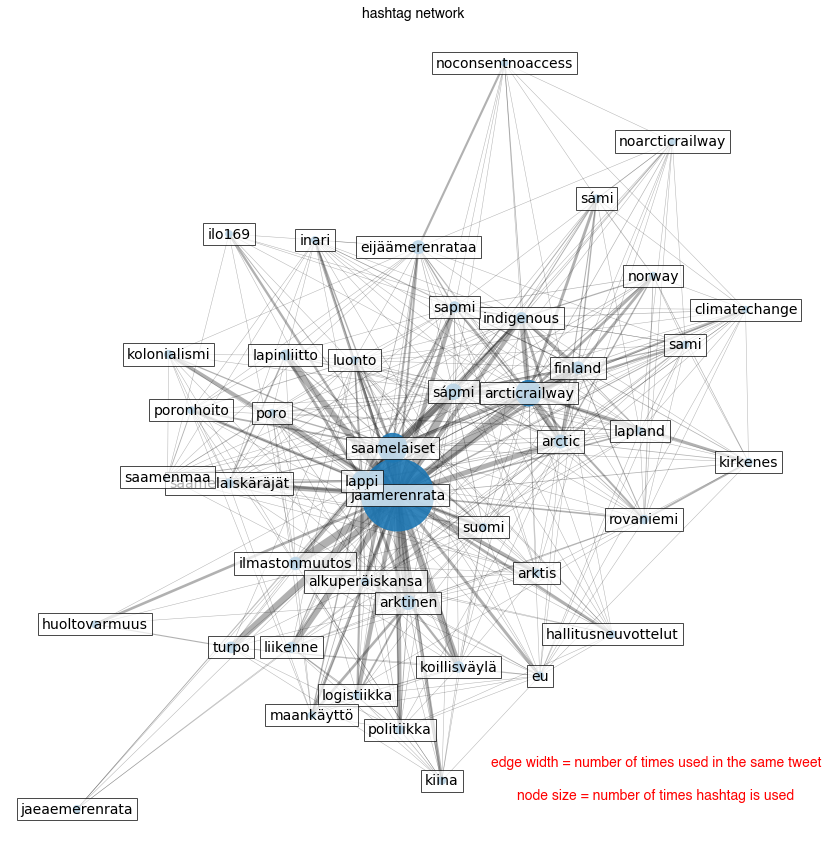

In [26]:
hashtags = text_xlsx['hashtags']
G_hash1 = create_hashtag_network(hashtags)
G_hash1, hashtag_freq = reduce_network_size(G_hash1, hashtags,20,10)

plot_spring(G_hash1,size_parameter = [hashtag_freq[v] * 2 for v in G_hash1.nodes()],title="hashtag network", print_labels = True)

In [29]:
import operator
sorted(hashtag_freq.items(), key=operator.itemgetter(1), reverse = True )[0:20]

[('jäämerenrata', 2600),
 ('saamelaiset', 417),
 ('arcticrailway', 327),
 ('lappi', 197),
 ('sápmi', 121),
 ('arktinen', 99),
 ('eijäämerenrataa', 83),
 ('arctic', 83),
 ('ilmastonmuutos', 77),
 ('finland', 70),
 ('indigenous', 59),
 ('turpo', 57),
 ('sapmi', 56),
 ('koillisväylä', 55),
 ('liikenne', 51),
 ('lapinliitto', 50),
 ('saamelaiskäräjät', 41),
 ('logistiikka', 35),
 ('politiikka', 35),
 ('rovaniemi', 35)]

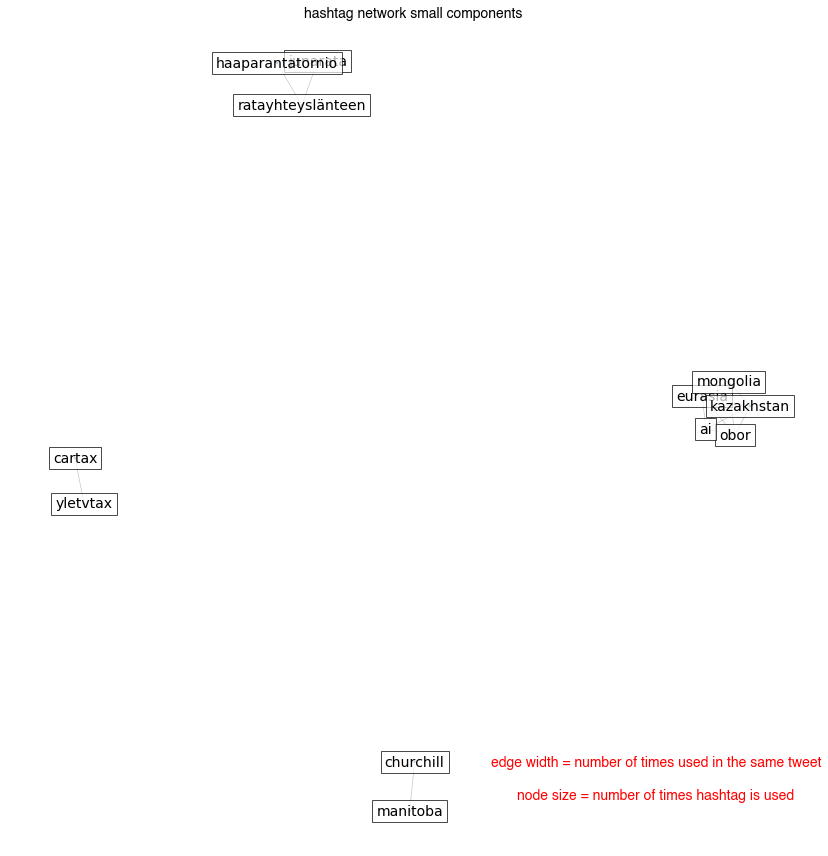

In [30]:
hashtags = df['hashtags']
G_hash1 = create_hashtag_network(hashtags)

G_hash1, hashtag_freq = reduce_network_size(G_hash1, hashtags,0,20,small_component = True)



plot_spring(G_hash1,size_parameter = [hashtag_freq[v] * 2 for v in G_hash1.nodes()],title="hashtag network small components", print_labels = True)

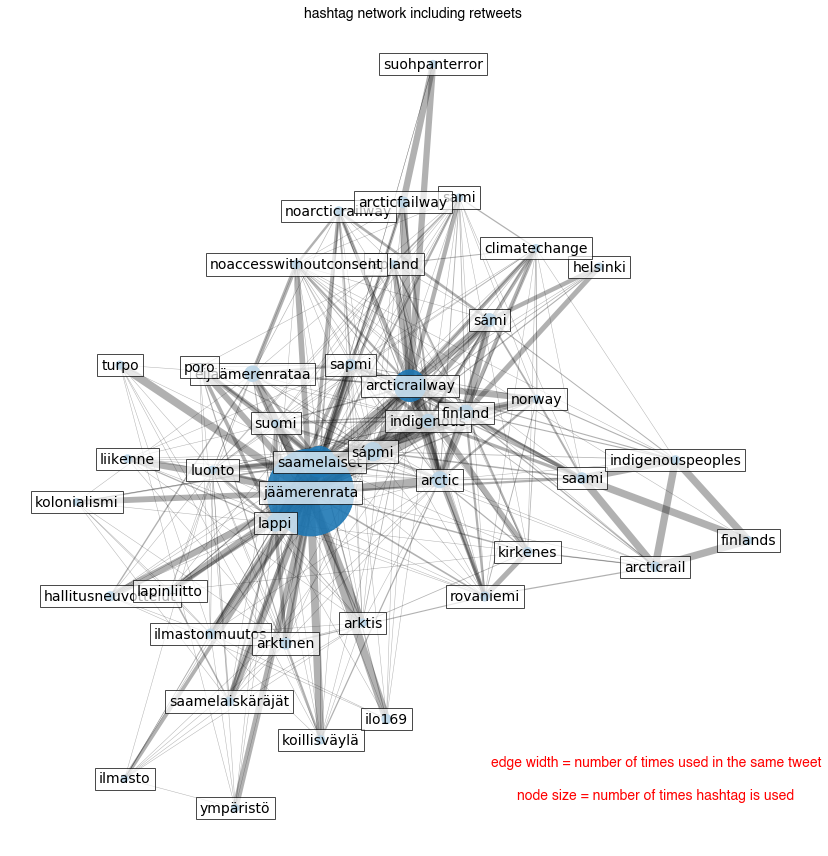

In [31]:
hashtags = df['hashtags']
G_hash1 = create_hashtag_network(hashtags)

G_hash1, hashtag_freq = reduce_network_size(G_hash1, hashtags,50,10)



plot_spring(G_hash1,size_parameter = [hashtag_freq[v] * 1 for v in G_hash1.nodes()],title="hashtag network including retweets", print_labels = True)

# Retweet networks

In [32]:
sorted(hashtag_freq.items(), key=operator.itemgetter(1), reverse = True )[0:20]

[('jäämerenrata', 7520),
 ('arcticrailway', 993),
 ('saamelaiset', 930),
 ('sápmi', 331),
 ('lappi', 271),
 ('arctic', 254),
 ('eijäämerenrataa', 241),
 ('finland', 239),
 ('indigenous', 183),
 ('sámi', 160),
 ('arktinen', 122),
 ('saami', 116),
 ('sapmi', 116),
 ('arcticfailway', 112),
 ('ilmastonmuutos', 96),
 ('arcticrail', 88),
 ('ilo169', 83),
 ('rovaniemi', 82),
 ('hallitusneuvottelut', 81),
 ('noarcticrailway', 81)]

In [33]:
mentions = text_xlsx['mentions']
mention_freq= {}
for i in mentions:
    for j in i:
        if j in mention_freq:
            mention_freq[j] += 1
        else:
            mention_freq[j] = 1
            
sorted_mention_freq = sorted(mention_freq.items(), key=operator.itemgetter(1), reverse = True )

In [73]:
sorted_mention_freq[0:20]

[('pvesterbacka', 167),
 ('PetraLaiti', 119),
 ('ArcticRailway', 116),
 ('AnneBerner', 79),
 ('lvmfi', 62),
 ('TiinaSaAi', 60),
 ('LapinLiitto', 57),
 ('Saamelaiskaraja', 46),
 ('hirvasjanne', 39),
 ('neetainari', 37),
 ('outilansman', 36),
 ('biret', 36),
 ('Nakkalajarvi', 32),
 ('noarcticrailway', 32),
 ('KatriKulmuni', 28),
 ('KarnaMikko', 22),
 ('annikoivisto', 17),
 ('MarkusLohi', 17),
 ('GreenpeaceSuomi', 17),
 ('TuuliMiettunen', 16)]

In [40]:
G_new, author_size, _ = retweet_network(df,[])

kawai_pre = nx.kamada_kawai_layout(G_new)

tweet: 935795618290847744  not found
tweet: 935796913290514432  not found
tweet: 1128238737958240259  not found
tweet: 1126382828151889920  not found
tweet: 1126846895589142528  not found
tweet: 1122916599953022976  not found
tweet: 1121722029726666752  not found
tweet: 1116237882962907137  not found
tweet: 1113421783699525637  not found
tweet: 1113422953826476034  not found
tweet: 1108276830514098176  not found
tweet: 1103926589392187392  not found
tweet: 1095999197751463936  not found
tweet: 1100814235104436224  not found
tweet: 976171647479803909  not found
tweet: 935796283746455552  not found
tweet: 935795912663805952  not found
tweet: 935797822594732033  not found
tweet: 935797722816401408  not found
tweet: 935797652939296768  not found
tweet: 935797042772922368  not found
tweet: 935796717303328768  not found
tweet: 935796471986782209  not found
tweet: 935796362783883264  not found
tweet: 935796169103564802  not found
tweet: 935796094847606785  not found
tweet: 1366385486953078786

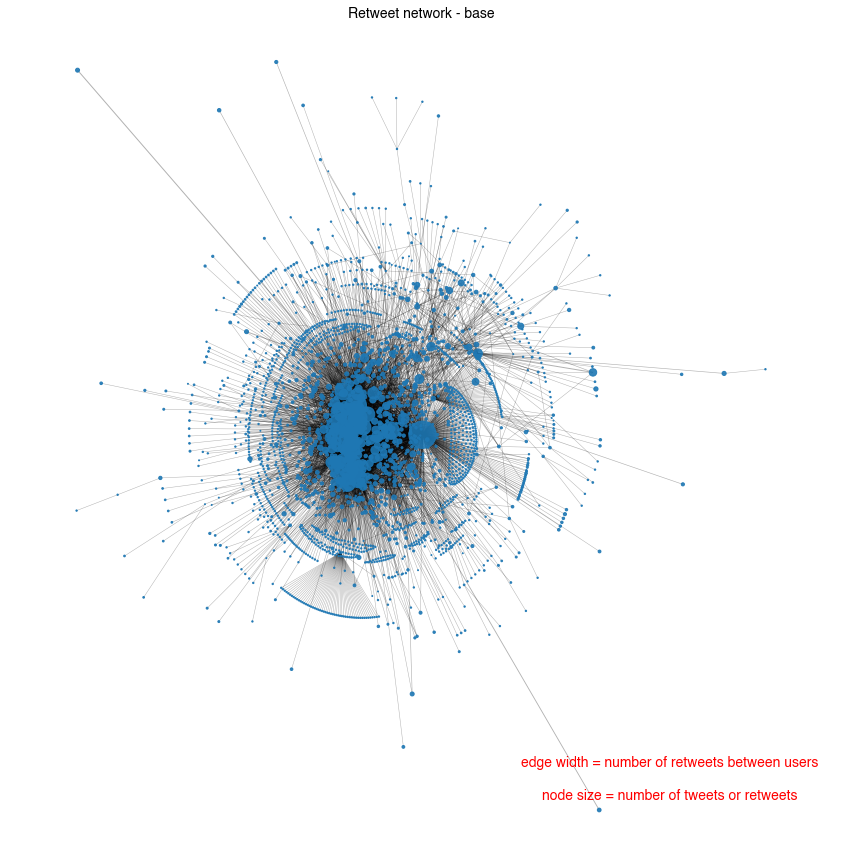

In [45]:
plot_kamada_kawai(G_new,size_parameter = [author_size[v] * 1 for v in G_new.nodes()], title ='Retweet network - base',
                  custom_colors = None,print_labels=False,custom_labels = None, presetlayout = kawai_pre)

tweet: 935795618290847744  not found
tweet: 935796913290514432  not found
tweet: 1128238737958240259  not found
tweet: 1126382828151889920  not found
tweet: 1126846895589142528  not found
tweet: 1122916599953022976  not found
tweet: 1121722029726666752  not found
tweet: 1116237882962907137  not found
tweet: 1113421783699525637  not found
tweet: 1113422953826476034  not found
tweet: 1108276830514098176  not found
tweet: 1103926589392187392  not found
tweet: 1095999197751463936  not found
tweet: 1100814235104436224  not found
tweet: 976171647479803909  not found
tweet: 935796283746455552  not found
tweet: 935795912663805952  not found
tweet: 935797822594732033  not found
tweet: 935797722816401408  not found
tweet: 935797652939296768  not found
tweet: 935797042772922368  not found
tweet: 935796717303328768  not found
tweet: 935796471986782209  not found
tweet: 935796362783883264  not found
tweet: 935796169103564802  not found
tweet: 935796094847606785  not found
tweet: 1366385486953078786

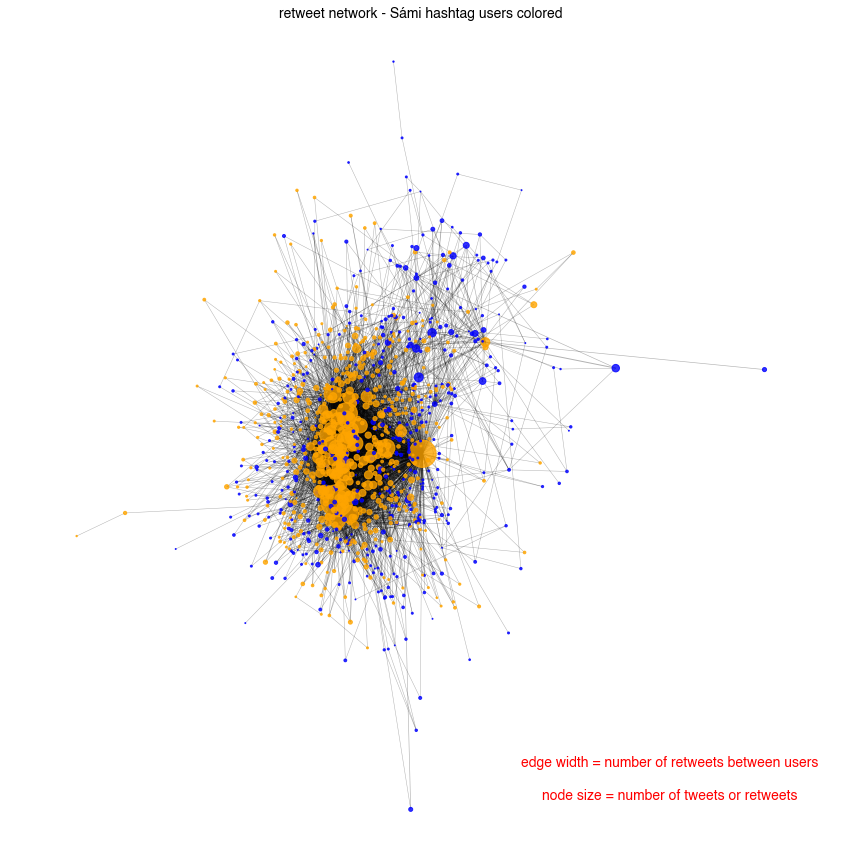

In [50]:
G_new, author_size, colors = retweet_network(df,saami_hash)

G_reduced = reduce_retweet_network(G_new,2,6)

mentions = []

for i in sorted_mention_freq[0:20]:
    mentions.append(i[0])

labels = custom_labels(G_new,users_dict,mentions)

cols = paint_colors(G_reduced,colors,('orange','blue'))

plot_kamada_kawai(G_reduced,size_parameter = [author_size[v] * 1 for v in G_reduced.nodes()],
                  title = 'retweet network - Sámi hashtag users colored',custom_colors = cols,
                  print_labels=False,custom_labels = labels, presetlayout = kawai_pre)

tweet: 935795618290847744  not found
tweet: 935796913290514432  not found
tweet: 1128238737958240259  not found
tweet: 1126382828151889920  not found
tweet: 1126846895589142528  not found
tweet: 1122916599953022976  not found
tweet: 1121722029726666752  not found
tweet: 1116237882962907137  not found
tweet: 1113421783699525637  not found
tweet: 1113422953826476034  not found
tweet: 1108276830514098176  not found
tweet: 1103926589392187392  not found
tweet: 1095999197751463936  not found
tweet: 1100814235104436224  not found
tweet: 976171647479803909  not found
tweet: 935796283746455552  not found
tweet: 935795912663805952  not found
tweet: 935797822594732033  not found
tweet: 935797722816401408  not found
tweet: 935797652939296768  not found
tweet: 935797042772922368  not found
tweet: 935796717303328768  not found
tweet: 935796471986782209  not found
tweet: 935796362783883264  not found
tweet: 935796169103564802  not found
tweet: 935796094847606785  not found
tweet: 1366385486953078786

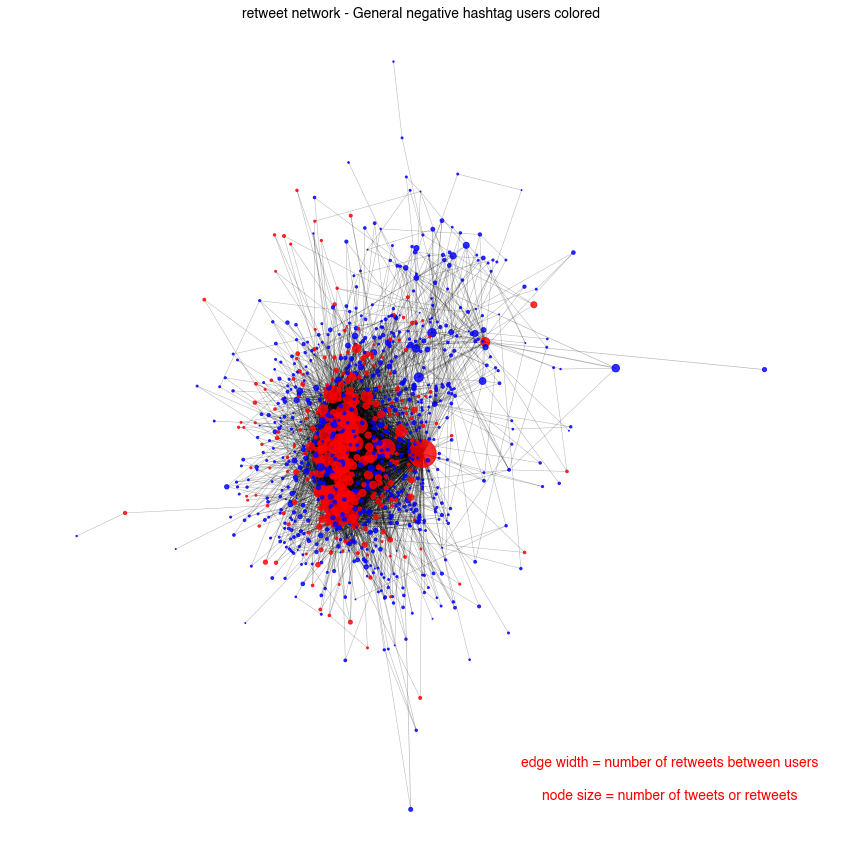

In [52]:
G_new, author_size, colors = retweet_network(df,negatiivinen)

G_reduced = reduce_retweet_network(G_new,2,6)

mentions = []

for i in sorted_mention_freq[0:20]:
    mentions.append(i[0])

labels = custom_labels(G_new,users_dict,mentions)

cols = paint_colors(G_reduced,colors,('red','blue'))

plot_kamada_kawai(G_reduced,size_parameter = [author_size[v] * 1 for v in G_reduced.nodes()],
                  title = 'retweet network - General negative hashtag users colored',custom_colors = cols,
                  print_labels=False,custom_labels = labels, presetlayout = kawai_pre)

tweet: 935795618290847744  not found
tweet: 935796913290514432  not found
tweet: 1128238737958240259  not found
tweet: 1126382828151889920  not found
tweet: 1126846895589142528  not found
tweet: 1122916599953022976  not found
tweet: 1121722029726666752  not found
tweet: 1116237882962907137  not found
tweet: 1113421783699525637  not found
tweet: 1113422953826476034  not found
tweet: 1108276830514098176  not found
tweet: 1103926589392187392  not found
tweet: 1095999197751463936  not found
tweet: 1100814235104436224  not found
tweet: 976171647479803909  not found
tweet: 935796283746455552  not found
tweet: 935795912663805952  not found
tweet: 935797822594732033  not found
tweet: 935797722816401408  not found
tweet: 935797652939296768  not found
tweet: 935797042772922368  not found
tweet: 935796717303328768  not found
tweet: 935796471986782209  not found
tweet: 935796362783883264  not found
tweet: 935796169103564802  not found
tweet: 935796094847606785  not found
tweet: 1366385486953078786

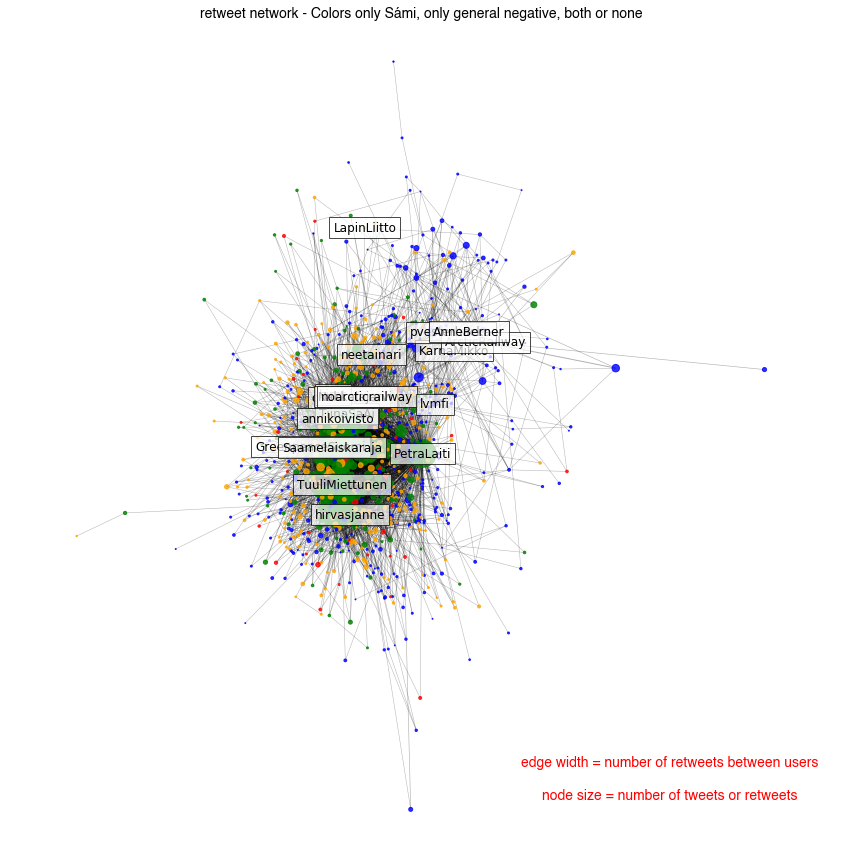

In [54]:
G_new, author_size, colors_neg = retweet_network(df,negatiivinen)
_, _, colors_saame = retweet_network(df,saami_hash)

G_reduced = reduce_retweet_network(G_new,2,6)

mentions = []

for i in sorted_mention_freq[0:20]:
    mentions.append(i[0])

labels = custom_labels(G_new,users_dict,mentions)

cols = paint_colors_4(G_reduced,colors_saame,colors_neg,('green','orange','red','blue'))

plot_kamada_kawai(G_reduced,size_parameter = [author_size[v] * 1 for v in G_reduced.nodes()],
                  title = 'retweet network - Colors only Sámi, only general negative, both or none',custom_colors = cols,
                  print_labels=True,custom_labels = labels, presetlayout = kawai_pre)

tweet: 935795618290847744  not found
tweet: 935796913290514432  not found
tweet: 1128238737958240259  not found
tweet: 1126382828151889920  not found
tweet: 1126846895589142528  not found
tweet: 1122916599953022976  not found
tweet: 1121722029726666752  not found
tweet: 1116237882962907137  not found
tweet: 1113421783699525637  not found
tweet: 1113422953826476034  not found
tweet: 1108276830514098176  not found
tweet: 1103926589392187392  not found
tweet: 1095999197751463936  not found
tweet: 1100814235104436224  not found
tweet: 976171647479803909  not found
tweet: 935796283746455552  not found
tweet: 935795912663805952  not found
tweet: 935797822594732033  not found
tweet: 935797722816401408  not found
tweet: 935797652939296768  not found
tweet: 935797042772922368  not found
tweet: 935796717303328768  not found
tweet: 935796471986782209  not found
tweet: 935796362783883264  not found
tweet: 935796169103564802  not found
tweet: 935796094847606785  not found
tweet: 1366385486953078786

<BarContainer object of 4 artists>

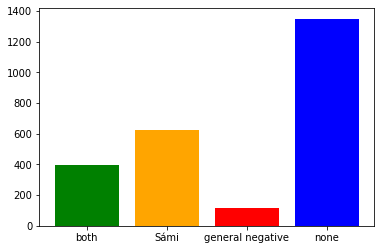

In [78]:
G_new, _, _ = retweet_network(df,[])
cols = paint_colors_4(G_new,colors_saame,colors_neg,('green','orange','red','blue'))
barp = [0,0,0,0]
for i in cols:
    if i == 'green':
        barp[0] += 1
    elif i == 'orange':
        barp[1] += 1
    elif i == 'red':
        barp[2] += 1
    else:
        barp[3] += 1

plt.bar(['both','Sámi','general negative','none'], barp,  color = ["green","orange","red","blue"])

In [79]:
barp

[397, 623, 119, 1350]